In [1]:
from itertools import islice

import os
import numpy as np
import tensorflow as tf
import python_speech_features as psp
import IPython
from IPython.display import Audio, display
from scipy.io import wavfile

%matplotlib inline
import matplotlib.pyplot as plt

from utils.wav_iterator import wav_batches, wav_iterator

audio_dir = os.environ['AUDIO_PATH']

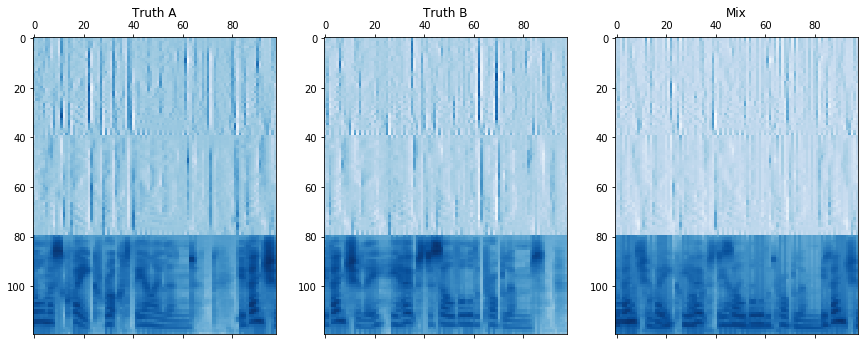

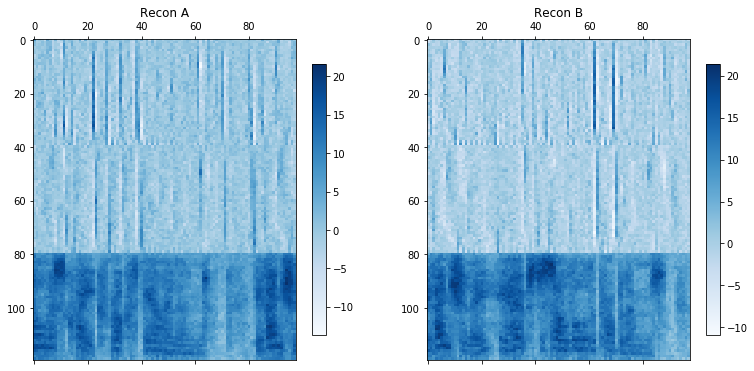

In [2]:
sb = wav_iterator(1, audio_dir, nfilters=40, stft_len=1024, nfft=4096)
def plot_mix(src1, src2, mix):
    """
    Plot original data
    """
    plt.figure(figsize=(20,10))
    ax = plt.subplot(1,4,1)
    ax.set_title("Truth A")
    ax.matshow(np.rot90(src1), cmap="Blues", interpolation='none')
    ax = plt.subplot(1,4,2)
    ax.set_title("Truth B")
    ax.matshow(np.rot90(src2), cmap="Blues", interpolation='none')
    ax = plt.subplot(1,4,3)
    ax.set_title("Mix")
    ax.matshow(np.rot90(mix), cmap="Blues", interpolation='none')


def plot_recons(src_recon1, src_recon2):
    """
    Plot reconstructions
    """
    plt.figure(figsize=(20,10))
    ax = plt.subplot(1,3,1)
    ax.set_title("Recon A")
    im = ax.matshow(np.rot90(src_recon1), cmap="Blues", interpolation='none')
    plt.colorbar(im, shrink=0.5)
    ax = plt.subplot(1,3,2)
    ax.set_title("Recon B")
    im = ax.matshow(np.rot90(src_recon2), cmap="Blues", interpolation='none')
    plt.colorbar(im, shrink=0.5)
    
    
for t, m in sb:
    plot_mix(t[0], t[1], m)
    plot_recons(t[0]+np.random.randn(*t[0].shape), 
                t[1]+np.random.randn(*t[1].shape))
    plt.show()

Implementation of the network

![MSS RNN Map](pics/rnn_map.png "Monaural source separation RNN Layout")

In [6]:
batch_size = 10
num_steps = 98
input_shape = 120
ff1_size = 80
recurrent_size = 50
ff2_size = 80


tf.reset_default_graph()
sess = tf.Session()
with sess.as_default():
    logmf_features = tf.placeholder(tf.float32, shape=(None, num_steps, input_shape), name="logmf_features")
    logmf_truth = tf.placeholder(tf.float32, shape=(None, 2, num_steps, input_shape), name="logmf_truth")
    ## Set up network
    # Feedforward 1
    feedforward_weights = tf.Variable(tf.random_normal((input_shape, ff1_size)), name="dense_wts_1")
    feedforward_bias = tf.Variable(tf.zeros((1, ff1_size)), name="dense_bias_1")
    # Recurrent layer
    recurrent_cell = tf.contrib.rnn.BasicRNNCell(recurrent_size)
    recurrent_state = recurrent_cell.zero_state(batch_size, logmf_features.dtype)
    # Feedforward 2
    feedforward_2_weights = tf.Variable(tf.random_normal((recurrent_size, ff2_size)), name="dense_wts_2")
    feedforward_2_bias = tf.Variable(tf.zeros((1, ff2_size)), name="dense_bias_2")
    # Preconstruction a (y_hat)
    precon_a_weights = tf.Variable(tf.random_normal((ff2_size, input_shape)), name="precon_a_wts")
    precon_a_bias = tf.Variable(tf.random_normal((1, input_shape)), name="precon_a_bias")
    # Preconstruction b
    precon_b_weights = tf.Variable(tf.random_normal((ff2_size, input_shape)), name="precon_b_wts")
    precon_b_bias = tf.Variable(tf.random_normal((1, input_shape)), name="precon_b_bias")
    # Mask
    mask_weights = tf.Variable(tf.random_normal((1,input_shape)), name="mask_wts")
    
    # Set up operations
    recons = {'a':[], 'b': []}
    for input_time in range(num_steps):
        if input_time > 0:
            tf.get_variable_scope().reuse_variables()
        # Feedforward 1 ops
        if input_time==0:
            print(logmf_features[:, input_time, :])
            print(feedforward_weights.value())

        feedforward_out = tf.matmul(logmf_features[:, input_time, :],feedforward_weights) + feedforward_bias
        feedforward_out = tf.nn.relu(feedforward_out)
        if input_time==0:
            print(feedforward_out)
        # Recurrent ops
        recurrent_output, recurrent_state = recurrent_cell(feedforward_out, recurrent_state)
        recurrent_output = tf.nn.relu(recurrent_output)
        if input_time<2:
            print(recurrent_output)
            print(recurrent_state)
        # Feedforward 2 ops
        feedforward_2_out = tf.matmul(recurrent_output,feedforward_2_weights) + feedforward_2_bias
        feedforward_2_out = tf.nn.relu(feedforward_2_out)
        if input_time==0:
            print(feedforward_2_out)
        # "Preconstruction" a/b
        precon_a = tf.matmul(feedforward_2_out,precon_a_weights) + precon_a_bias
        precon_b = tf.matmul(feedforward_2_out,precon_b_weights) + precon_b_bias
        if input_time==0:
            print("Preconstruction size")
            print(precon_a)
            print(precon_b)
        # Apply mask for final reconstruction
        recon_a = tf.multiply(precon_a / (precon_a+precon_b), mask_weights)
        recon_b = tf.multiply(precon_b / (precon_a+precon_b), mask_weights)
        recons['a'].append(recon_a)
        recons['b'].append(recon_b)
    out_a = tf.stack(recons['a'], axis=1)
    out_b = tf.stack(recons['b'], axis=1)
    out_pair = tf.stack((out_a,out_b), axis=1)
    print(out_pair)
    loss = tf.reduce_mean(tf.squared_difference(out_pair, logmf_truth))     

Tensor("strided_slice:0", shape=(?, 120), dtype=float32)
Tensor("dense_wts_1/read:0", shape=(120, 80), dtype=float32)
Tensor("Relu:0", shape=(?, 80), dtype=float32)
Tensor("Relu_1:0", shape=(10, 50), dtype=float32)
Tensor("basic_rnn_cell/Tanh:0", shape=(10, 50), dtype=float32)
Tensor("Relu_2:0", shape=(10, 80), dtype=float32)
Preconstruction size
Tensor("add_2:0", shape=(10, 120), dtype=float32)
Tensor("add_3:0", shape=(10, 120), dtype=float32)
Tensor("Relu_4:0", shape=(10, 50), dtype=float32)
Tensor("basic_rnn_cell_1/Tanh:0", shape=(10, 50), dtype=float32)
Tensor("stack_3:0", shape=(10, 2, 98, 120), dtype=float32)


Feed-forward and loss calculation

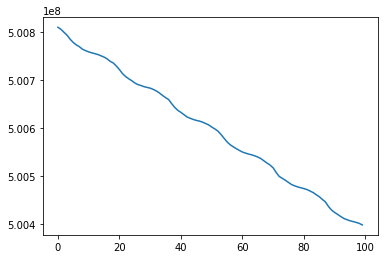

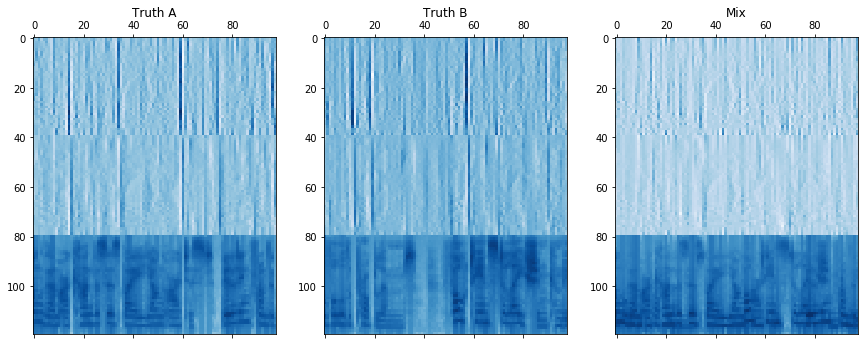

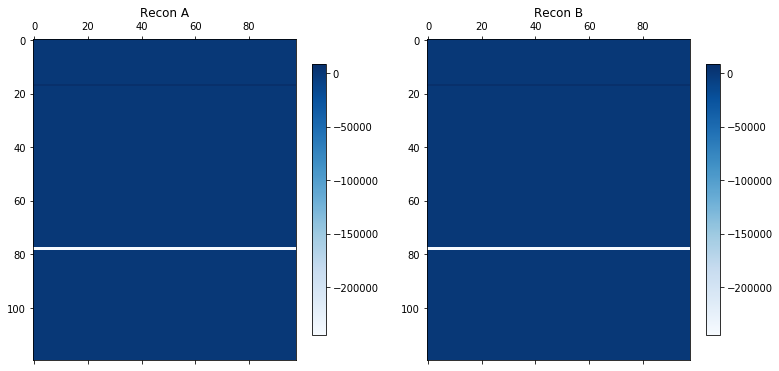

In [9]:
# Unending iterator
batches = wav_batches(batch_size, audio_dir)

# Optimization loop
with sess.as_default():
    tf.global_variables_initializer().run()
    optimizer = tf.train.GradientDescentOptimizer(0.001)
    descent_step = optimizer.minimize(loss)
    losses = []
    for truth, mix in islice(batches, 100):
        data = {logmf_features: mix,
                logmf_truth: truth}
        descent_step.run(feed_dict=data)        
        losses.append(loss.eval(feed_dict=data))
        if len(losses) % 10 == 0:
            IPython.display.clear_output(wait=True)
            plt.plot(range(len(losses)), losses)
            # pull out an example and plot it
            out_a_img = out_a[0].eval(feed_dict=data)
            out_b_img = out_b[0].eval(feed_dict=data)
            plot_mix(truth[0, 0], truth[0, 1], mix[0])
            plot_recons(out_a_img, out_b_img)
            plt.show()
